<a href="https://colab.research.google.com/github/saksham1965/Project/blob/main/ML%20lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')


In [4]:

# Load datasets
train = pd.read_csv('sales_train.csv')
test = pd.read_csv('test.csv')
items = pd.read_csv('items.csv')
item_categories = pd.read_csv('item_categories.csv')
shops = pd.read_csv('shops.csv')

# Merge datasets
train = train.merge(items, on='item_id', how='left')
train = train.merge(item_categories, on='item_category_id', how='left')
train = train.merge(shops, on='shop_id', how='left')


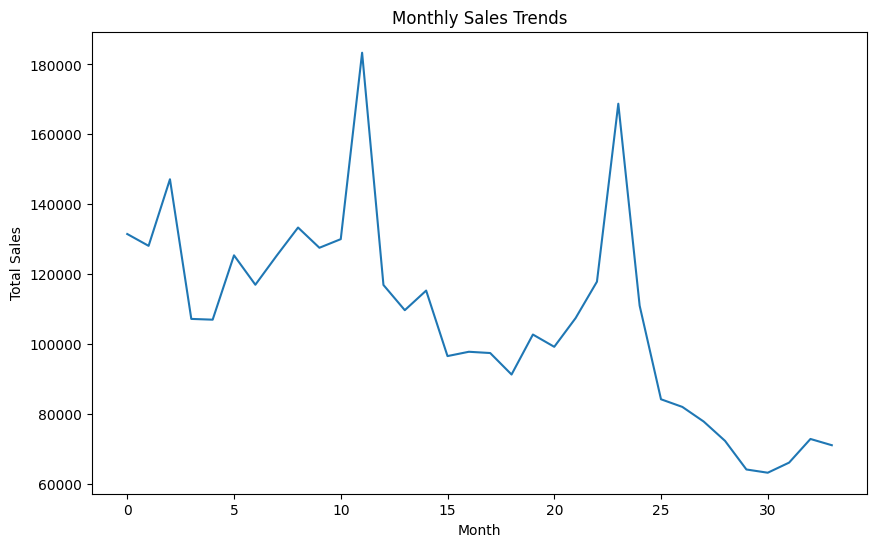

In [5]:
# Aggregate sales by month
monthly_sales = train.groupby('date_block_num')['item_cnt_day'].sum()

# Plot sales trends
plt.figure(figsize=(10, 6))
monthly_sales.plot(title='Monthly Sales Trends')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.show()


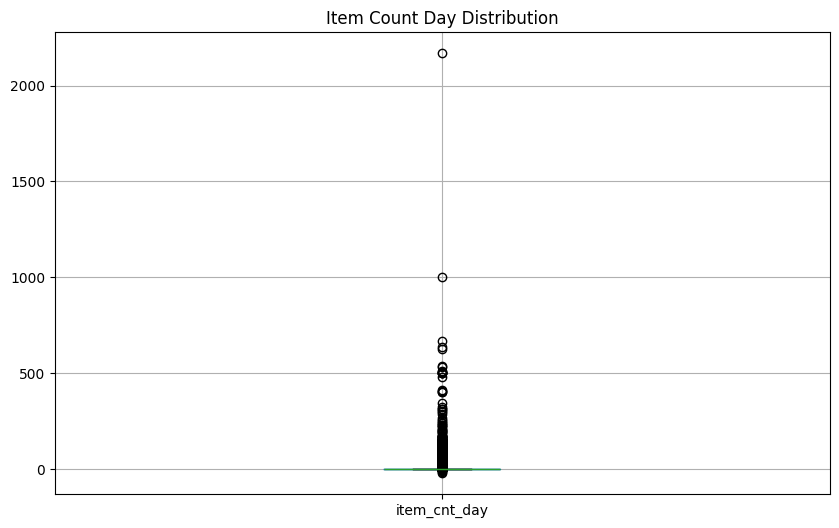

In [6]:
# Boxplot to detect outliers
plt.figure(figsize=(10, 6))
train.boxplot(column='item_cnt_day')
plt.title('Item Count Day Distribution')
plt.show()



In [7]:
# Fill missing values
train.fillna({'item_price': train['item_price'].median()}, inplace=True)

# Encode categorical variables
train['shop_name_encoded'] = train['shop_name'].astype('category').cat.codes
train['item_category_name_encoded'] = train['item_category_name'].astype('category').cat.codes



In [8]:
# Aggregate sales data by month
monthly_sales = train.groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False).agg(
    item_cnt_month=('item_cnt_day', 'sum'),
    item_price=('item_price', 'mean')
)

# Clip item counts to handle outliers
monthly_sales['item_cnt_month'] = monthly_sales['item_cnt_month'].clip(0, 20)


In [9]:
# Lag features
monthly_sales['item_cnt_lag_1'] = monthly_sales.groupby(['shop_id', 'item_id'])['item_cnt_month'].shift(1)
monthly_sales['item_cnt_lag_2'] = monthly_sales.groupby(['shop_id', 'item_id'])['item_cnt_month'].shift(2)

# Rolling means
monthly_sales['item_cnt_roll_7'] = monthly_sales.groupby(['shop_id', 'item_id'])['item_cnt_month'].transform(lambda x: x.rolling(7).mean())

# Price trends
monthly_sales['item_price_diff'] = monthly_sales.groupby(['shop_id', 'item_id'])['item_price'].diff()


In [10]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np # Import numpy for sqrt

# Prepare training data
train_data = monthly_sales.dropna(subset=['item_cnt_month'])
X_train = train_data[['shop_id', 'item_id', 'date_block_num', 'item_price', 'item_cnt_lag_1', 'item_cnt_lag_2', 'item_cnt_roll_7']]
y_train = train_data['item_cnt_month']

# Train XGBoost model
model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)

# Predictions
y_pred = model_xgb.predict(X_train)

# Evaluate model
# Calculate Mean Squared Error first
mse = mean_squared_error(y_train, y_pred)
# Then take the square root to get RMSE
rmse = np.sqrt(mse)
print(f'XGBoost RMSE: {rmse}')

XGBoost RMSE: 1.8128840897027554


In [22]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Prepare data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(X_train)

# Reshape data for LSTM
X_lstm = scaled_data.reshape((scaled_data.shape[0], 1, scaled_data.shape[1]))

# Build LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_lstm.shape[1], X_lstm.shape[2])))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dense(units=1))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Train LSTM model
model_lstm.fit(X_lstm, y_train, epochs=10, batch_size=32)

# Predictions
y_pred_lstm = model_lstm.predict(X_lstm)

# Calculate Mean Squared Error first
mse = mean_squared_error(y_train, y_pred)
# Then take the square root to get RMSE
rmse = np.sqrt(mse)
rmse_lstm = mean_squared_error(y_train, y_pred_lstm, squared=False)
print(f'LSTM RMSE: {rmse_lstm}')


Epoch 1/10
50286/50286 ━━━━━━━━━━━━━━━━━━━━ 180s 3ms/step - loss: 4.7424
Epoch 2/10
50286/50286 ━━━━━━━━━━━━━━━━━━━━ 198s 3ms/step - loss: 4.4849
Epoch 3/10
50286/50286 ━━━━━━━━━━━━━━━━━━━━ 203s 3ms/step - loss: 4.4044
Epoch 4/10
50286/50286 ━━━━━━━━━━━━━━━━━━━━ 206s 4ms/step - loss: 4.3854
Epoch 5/10
50286/50286 ━━━━━━━━━━━━━━━━━━━━ 172s 3ms/step - loss: 4.3451
Epoch 6/10
50286/50286 ━━━━━━━━━━━━━━━━━━━━ 202s 3ms/step - loss: 4.3371
Epoch 7/10
50286/50286 ━━━━━━━━━━━━━━━━━━━━ 208s 4ms/step - loss: 4.3060
Epoch 8/10
50286/50286 ━━━━━━━━━━━━━━━━━━━━ 196s 3ms/step - loss: 4.3372
Epoch 9/10
50286/50286 ━━━━━━━━━━━━━━━━━━━━ 202s 3ms/step - loss: 4.2797
Epoch 10/10
50286/50286 ━━━━━━━━━━━━━━━━━━━━ 178s 4ms/step - loss: 4.2900
50286/50286 ━━━━━━━━━━━━━━━━━━━━ 78s 2ms/step


TypeError: got an unexpected keyword argument 'squared'

In [24]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error # Ensure this is imported if not already
import numpy as np # Ensure numpy is imported if not already

# Prepare data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(X_train)

# Reshape data for LSTM
X_lstm = scaled_data.reshape((scaled_data.shape[0], 1, scaled_data.shape[1]))

# Build LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=100, return_sequences=True, input_shape=(X_lstm.shape[1], X_lstm.shape[2])))
model_lstm.add(LSTM(units=100))
model_lstm.add(Dense(units=1))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Train LSTM model
model_lstm.fit(X_lstm, y_train, epochs=3, batch_size=32)

# Predictions
y_pred_lstm = model_lstm.predict(X_lstm)

# Evaluate model
# Calculate Mean Squared Error first
mse_lstm = mean_squared_error(y_train, y_pred_lstm)
# Then take the square root to get RMSE
rmse_lstm = np.sqrt(mse_lstm)
print(f'LSTM RMSE: {rmse_lstm}')

Epoch 1/3
50286/50286 ━━━━━━━━━━━━━━━━━━━━ 221s 4ms/step - loss: 4.7238
Epoch 2/3
50286/50286 ━━━━━━━━━━━━━━━━━━━━ 220s 4ms/step - loss: 4.4269
Epoch 3/3
50286/50286 ━━━━━━━━━━━━━━━━━━━━ 275s 5ms/step - loss: 4.3722
50286/50286 ━━━━━━━━━━━━━━━━━━━━ 94s 2ms/step
LSTM RMSE: 2.0872097325401002


In [28]:
from flask import Flask, request, jsonify
import numpy as np

app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json()
    # Prepare data for prediction
    input_data = np.array([data['shop_id'], data['item_id'], data['date_block_num'], data['item_price']]).reshape(1, -1)
    # Predict using XGBoost model
    prediction = model_xgb.predict(input_data)
    return jsonify({'predicted_sales': prediction[0]})

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


In [30]:
# Evaluate XGBoost model
y_pred_xgb = model_xgb.predict(X_train)
# Calculate Mean Squared Error first
mse_xgb = mean_squared_error(y_train, y_pred_xgb)
# Then take the square root to get RMSE
rmse_xgb = np.sqrt(mse_xgb)
print(f'XGBoost RMSE: {rmse_xgb}')

# Evaluate LSTM model
y_pred_lstm = model_lstm.predict(X_lstm)
# Calculate Mean Squared Error first
mse_lstm = mean_squared_error(y_train, y_pred_lstm)
# Then take the square root to get RMSE
rmse_lstm = np.sqrt(mse_lstm)
print(f'LSTM RMSE: {rmse_lstm}')


XGBoost RMSE: 1.8103193219430511
50286/50286 ━━━━━━━━━━━━━━━━━━━━ 89s 2ms/step
LSTM RMSE: 2.0872097325401002
